In [1]:
#loading the dataset

import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from imageio import imsave
from tqdm import tqdm
import random
import shutil

HEIGHT = 96
WIDTH = 96
DEPTH = 3

SIZE = HEIGHT * WIDTH * DEPTH

DATA_DIR = './'
# DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

TRAIN_DATA_PATH = '../input/stl10-binary-files/stl10_binary/train_X.bin'
TRAIN_LABEL_PATH = '../input/stl10-binary-files/stl10_binary/train_y.bin'

TEST_DATA_PATH = '../input/stl10-binary-files/stl10_binary/test_X.bin'
TEST_LABEL_PATH = '../input/stl10-binary-files/stl10_binary/test_y.bin'

UNLAB_DATA_PATH = '../input/stl10-binary-files/stl10_binary/unlabeled_X.bin'

In [2]:
def read_single_image(image_file):

  image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)

  image = np.reshape(image, (3, 96, 96))
  image = np.transpose(image, (2, 1, 0))
  return image

def plot_image(image):
  
  plt.imshow(image)
  plt.show()

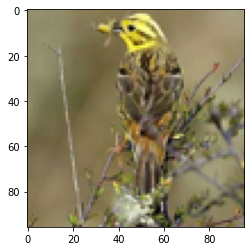

In [3]:
with open(TRAIN_DATA_PATH) as f:
  image = read_single_image(f)
  plot_image(image)

In [4]:
def read_labels(path_to_labels):

    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

def read_all_images(path_to_data):

    with open(path_to_data, 'rb') as f:
        everything = np.fromfile(f, dtype=np.uint8)

        images = np.reshape(everything, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
        return images

def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def save_images(images, labels, types):
    i = 0
    for image in tqdm(images, position=0):
        label = labels[i] 
        directory = DATA_DIR + '/' + types + '/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        #print(filename)
        save_image(image, filename)
        i = i+1
        
def save_unlabelled_images(images):
    i = 0
    for image in tqdm(images, position=0):
        directory = DATA_DIR + '/' + 'unlabelled' + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        save_image(image, filename)
        i = i+1 
        

def create_val_dataset():
    train_image_path = DATA_DIR + "train"
    folders = os.listdir(train_image_path)

    for folder in tqdm(folders, position=0):
        temp_dir = DATA_DIR +"/train/" + folder
        temp_image_list = os.listdir(temp_dir)

    for i in range(50):
        val_dir = DATA_DIR + "/val/" + folder
        try:
            os.makedirs(val_dir, exist_ok=True)
        except OSError as exc:

            if exc.errno == errno.EEXIST:
                pass
        image_name = random.choice(temp_image_list)
        temp_image_list.remove(image_name)
        old_name = temp_dir + '/' + image_name
        new_name = val_dir + '/' + image_name
        os.replace(old_name, new_name)

In [5]:
#loading the dataset
train_labels = read_labels(TRAIN_LABEL_PATH)
train_images = read_all_images(TRAIN_DATA_PATH)

test_labels = read_labels(TEST_LABEL_PATH)
test_images = read_all_images(TEST_DATA_PATH)

unlabelled_images = read_all_images(UNLAB_DATA_PATH)

In [6]:
np.max(test_labels), np.min(test_labels)

(10, 1)

In [7]:
test_labels = test_labels - 1
train_labels = train_labels - 1

In [8]:
train_images.shape,train_labels.shape
train_labels = train_labels.reshape(-1,1)

#normalizing the data
train_images = train_images/255
test_images = test_images/255


In [9]:
#splitting the training set into training and validation set
train_images_1 = train_images[0:4500]
train_labels_1 = train_labels[0:4500]

val_images = train_images[4500:]
val_labels = train_labels[4500:]

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers


In [11]:
#building the model

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),
    include_top=False)  

    base_model.trainable = False
    inputs = keras.Input(shape=(96, 96, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(300, activation = 'relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(10, activation = 'softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'],  steps_per_execution=32)

# train model normally
model.fit(train_images_1, train_labels_1, epochs=20, batch_size = 1024)


80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/20
5/5 [==============================] - 15s 3s/step - loss: 2.3290 - accuracy: 0.1469
Epoch 2/20
5/5 [==============================] - 0s 26ms/step - loss: 1.9595 - accuracy: 0.3153
Epoch 3/20
5/5 [==============================] - 0s 24ms/step - loss: 1.7020 - accuracy: 0.4164
Epoch 4/20
5/5 [==============================] - 0s 23ms/step - loss: 1.5108 - accuracy: 0.4844
Epoch 5/20
5/5 [==============================] - 0s 24ms/step - loss: 1.3869 - accuracy: 0.5240
Epoch 6/20
5/5 [==============================] - 0s 23ms/step - loss: 1.2979 - accuracy: 0.5513
Epoch 7/20
5/5 [==============================] - 0s 24ms/step - loss: 1.2268 - accuracy: 0.5756
Epoch 8/20
5/5 [==============================] - 0s 24ms/step - loss: 1.1642 - accuracy: 0.5984
Epoch 9/20
5/5 [==============================] - 0s 23ms/step - loss: 1.1193 - accuracy: 0.6084
Epoch 10/20
5/5 [==============================] - 0s 24ms/step

In [12]:
loss, acc = model.evaluate(test_images, test_labels)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

250/250 [==============================] - 5s 20ms/step - loss: 0.9318 - accuracy: 0.6656
loss: 0.93
acc: 0.67


In [13]:
unlabelled_images = unlabelled_images.reshape(-1,96*96*3)
unlabelled_images.shape

(100000, 27648)

In [16]:
#using keras callbacks API to save the model with the best accuracy on the validation set
from keras.callbacks import ModelCheckpoint
filepath="model.{epoch:03d}-{val_accuracy:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', save_best_only = True, mode = 'max')

In [17]:
def train_model(train_images,train_labels):
    train_images = train_images.reshape(-1,96,96,3)
    model.fit(train_images, train_labels, epochs=3, batch_size = 1024,validation_data = (val_images,val_labels), callbacks = [checkpoint])

In [18]:
#Since the unlabelled dataset is huge, I will only try to pseudolabel 6.5k images 
#Dividing the batches such that the program goes through the entire dataset and not just one part of it
for i in range(0,1000,15):
    #pesudo-labelling the unlabelled images in batches of 100 images
    #the variable 'train_unlabeled_images' stores batches of unlabelled images 
    
    train_unlabeled_images = unlabelled_images[100*i:(i+1)*100]
    iterations = 0
    while(1):
        index =  0
        for row in train_unlabeled_images:
            
            #predicting the label for an unlabelled image
                image = row.reshape(-1,96,96,3)
                prob_distr = model.predict(image)
                
            #getting the probability that the predicted label is correct
                prob = np.max(prob_distr)
                label = np.argmax(prob_distr)
                
            #appending the image and label to the training dataset if the probability of the predicted label being correct is more than 0.99
                if (prob > 0.99):
                    train_images_1 = np.append(train_images_1,image)
                    train_labels_1 = np.append(train_labels_1,label)
            #deleting the selected image from the unlabelled dataset
                    train_unlabeled_images = np.delete(train_unlabeled_images, index, axis = 0)
                    index -= 1

                index += 1




        iterations += 1
            
            #terminating the loop and moving on to the next batch of unlabelled images after 4 iterations are completed
        if(iterations > 4):
            break
            
            #training the model after each iteration of pseudolabelling
        train_model(train_images_1,train_labels_1)
        print(i,iterations)


Epoch 1/3
5/5 [==============================] - 21s 4s/step - loss: 0.8758 - accuracy: 0.6945 - val_loss: 0.8938 - val_accuracy: 0.6860
Epoch 2/3
5/5 [==============================] - 1s 119ms/step - loss: 0.8476 - accuracy: 0.7095 - val_loss: 0.8987 - val_accuracy: 0.6880
Epoch 3/3
5/5 [==============================] - 1s 125ms/step - loss: 0.8401 - accuracy: 0.7095 - val_loss: 0.8820 - val_accuracy: 0.7080
0 1
Epoch 1/3
5/5 [==============================] - 6s 1s/step - loss: 0.8301 - accuracy: 0.7070 - val_loss: 0.8947 - val_accuracy: 0.6740
Epoch 2/3
5/5 [==============================] - 1s 131ms/step - loss: 0.8113 - accuracy: 0.7172 - val_loss: 0.8786 - val_accuracy: 0.6960
Epoch 3/3
5/5 [==============================] - 1s 122ms/step - loss: 0.8073 - accuracy: 0.7135 - val_loss: 0.8749 - val_accuracy: 0.6920
0 2
Epoch 1/3
5/5 [==============================] - 1s 184ms/step - loss: 0.7985 - accuracy: 0.7228 - val_loss: 0.8692 - val_accuracy: 0.7100
Epoch 2/3
5/5 [=========

In [19]:
loss, acc = model.evaluate(test_images, test_labels)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

250/250 [==============================] - 1s 4ms/step - loss: 1.2733 - accuracy: 0.7001
loss: 1.27
acc: 0.70


In [20]:
del model

In [22]:
# selecting the model with the highest accuracy on the validation set
# model = tf.keras.models.load_model(path_to_saved_model)
model = tf.keras.models.load_model('./model.001-0.742.h5')

In [23]:
loss, acc = model.evaluate(test_images, test_labels)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

250/250 [==============================] - 25s 97ms/step - loss: 0.8203 - accuracy: 0.7071
loss: 0.82
acc: 0.71
